# Purchase model using e-commerce data

### Import packages

In [1]:
# data processing
import numpy as np
import pandas as pd
from datetime import date

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Set-up

For this expercise, we will utilize two files (listed below) from the 'Brazilian E-Commerce Public Dataset' originally posted on [Kaggle]( https://www.kaggle.com/olistbr/brazilian-ecommerce).

In [2]:
# full path of the orders dataset
orders_file = '../data/olist_orders_dataset.csv'

# full path of the customer dataset
cust_file = '../data/olist_customers_dataset.csv'

### Read data

In [3]:
def read_olist_data(file1, file2, use_cols, cutoff_dt, verbose):
    
    # read the orders data
    orders = pd.read_csv(file1)

    if verbose:
        print (f'{len(orders):,} read from the orders file.')

    # date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

    # let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date

    # extract month from the order date
    orders['order_dow'] = orders['order_purchase_timestamp'].dt.day_name()

    # read the file that contains the unique customer identifier
    # also, let's keep only the following two columns: customer_id, customer_unique_id
    cust = pd.read_csv(file2, usecols=['customer_id', 'customer_unique_id'])
    
    if verbose:
        print (f'{len(cust):,} read from the customer file.')

    # merge orders and cust dataframes
    orders_out = pd.merge(orders, cust, on='customer_id', how='inner')
    
    # discard (incomplete) data after cutoff_dt
    # we do this here by using a boolean (True/False) mask
    mask = orders_out['order_purchase_date'] <= cutoff_dt

    orders_out = orders_out[mask]
    
    # sort the output dataset by order date for each customer
    orders_out = orders_out[use_cols].sort_values(['customer_unique_id', 'order_purchase_timestamp'])

    if verbose:
        print (f'{len(orders_out):,} records in the output  file.')
    
    return orders_out

In [4]:
# we will keep only these columns for this exercise
use_cols = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_dow']

# we will discard (incomplete) data after 8/22/18 (see 06_pandas_wrangle.ipynb for the rationale)
cutoff_date = date(2018, 8, 22)

orders = read_olist_data(orders_file, cust_file, use_cols, cutoff_date, 1)

99,441 read from the orders file.
99,441 read from the customer file.
98,906 records in the output  file.


This is our combined raw dataset from which we will create attributes and label for each customer.

## Binary Classification Model: Data Preparation

Let's build a model to predict whether a customer will make a purchase within the next month.

<img src="../misc/prediction-window.png" align=left width=750>

We will use *July 2018*, which is the most recent complete month, as the prediction window. In other words, we will use all available data prior to July 2018 to predict which customers will make a purchase in July 2018.

In [5]:
snapshot_date = date(2018, 6, 30)

### Attribute #1: Order recency

For creating model attributes (features) we will have to restrict our data to the timeframe prior to the prediction window.

In [6]:
mask = orders['order_purchase_timestamp'].dt.date <= snapshot_date


In [7]:
# apply the filter

df_raw = orders[mask]

len(orders), len(df_raw)

(98906, 86617)

In [8]:
# check the max date

df_raw.order_purchase_timestamp.max()

Timestamp('2018-06-30 23:59:49')

To calculate recency (days since the most recent order), we will have to extract *the most recent date* for each customer.

In [9]:
# grab the max purchase date for each customer

cust_recency = df_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

cust_recency.head()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [10]:
# count the number of days between the most recent order date and the snapshot date

delta = snapshot_date - cust_recency['order_purchase_timestamp'].dt.date

delta.head()

0    51 days
1    54 days
2   477 days
3   261 days
4   228 days
Name: order_purchase_timestamp, dtype: timedelta64[ns]

In [11]:
# grab the number of days (as an integer) from the calculated deltas 

cust_recency['order_recency'] = delta.dt.days / 30
cust_recency['order_recency'] = cust_recency['order_recency'].astype(int)
cust_recency.head()

,customer_unique_id,order_purchase_timestamp,order_recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,15
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,8
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,7


In [12]:
# drop the date (we don't need it any more for this exercise)

cust_recency = cust_recency.drop('order_purchase_timestamp', axis=1)

In [13]:
# how many records (unique customers) do we have for this timeframe?

len(cust_recency)

83748

This is the number of customers who are included in the modeling dasetset for this specific time-frame.

Let's check the distribution of this attribute.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


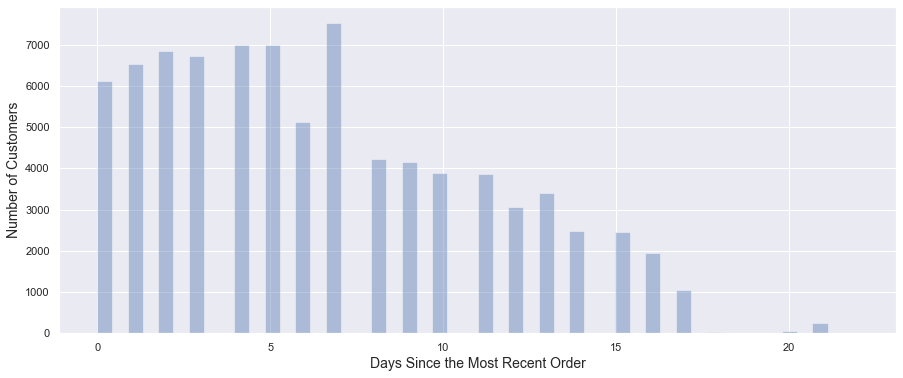

In [14]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(15, 6)

# histogram
sns.distplot(cust_recency['order_recency'], kde=False)

# assign axis labels
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel('Days Since the Most Recent Order', fontsize=14);

Let's take a look at the cumulative distribution of customers by recency.

In [15]:
recency_distr = cust_recency.groupby('order_recency').size().reset_index()

recency_distr = recency_distr.rename(columns={0: 'cust_count'})

recency_distr.head()

,order_recency,cust_count
0,0,6128
1,1,6526
2,2,6858
3,3,6717
4,4,6998


In [16]:
# calculate cumulative percentages 

cum_pctg = recency_distr['cust_count'].cumsum() / sum(recency_distr['cust_count'])

cum_pctg.head()

0    0.073172
1    0.151096
2    0.232985
3    0.313190
4    0.396750
Name: cust_count, dtype: float64

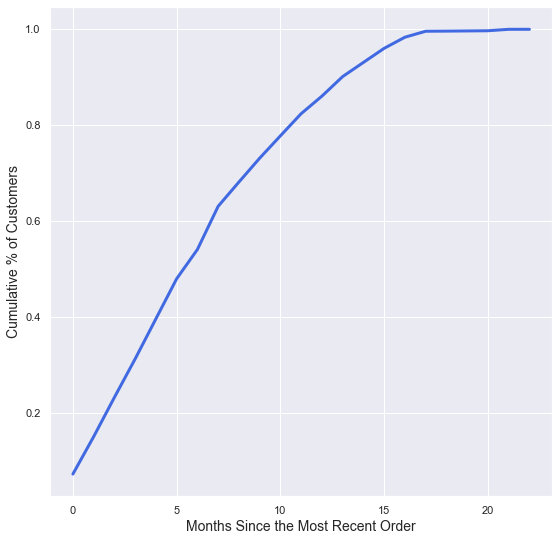

In [17]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(9, 9)

# histogram
sns.lineplot(x=recency_distr['order_recency'], y=cum_pctg, color='royalblue', lw=3)

# assign axis labels
plt.ylabel('Cumulative % of Customers', fontsize=14)
plt.xlabel('Months Since the Most Recent Order', fontsize=14);

Additional eligibility criteria can be applied to exclude customers (from the modeling dataset) who have not shopped in more than, e.g., one/two years.

### Attribute #2: Number of orders per customer

In [18]:
# count total records (i.e., orders) per customer

cust_orders = df_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'total_orders'})

cust_orders.head()

,customer_unique_id,total_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [19]:
cust_orders.total_orders.value_counts()

1     81174
2      2361
3       171
4        24
5         8
6         5
7         3
12        1
9         1
Name: total_orders, dtype: int64

### Attribute set #3: Weekday

In [20]:
df_raw.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_dow
52798,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,Thursday
73889,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,Monday
26460,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,Friday
98493,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,Thursday
41564,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,Tuesday


In [21]:
# get dummies

df_raw = pd.get_dummies(df_raw, columns=['order_dow'])

df_raw.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
52798,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,0,0,0,0,1,0,0
73889,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,0,1,0,0,0,0,0
26460,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,1,0,0,0,0,0,0
98493,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,0,0,0,0,1,0,0
41564,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,0,0,0,0,0,1,0


In [97]:
# grab all binary columns that we just created
dummies = [x for x in df_raw.columns if 'order_dow' in x]

# aggreagte data to the customer-level, so that we have one record per customer
cust_dow = df_raw.groupby('customer_unique_id')[dummies].sum().reset_index()

cust_dow.head()

,customer_unique_id,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,1,0,0,0,0,0
2,0000f46a3911fa3c0805444483337064,1,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,1,0


### Combine all attributes into a single dataframe

In [98]:
# let's check the number of records in each dataframe first

cust_recency.shape, cust_orders.shape, cust_dow.shape

((83748, 2), (83748, 2), (83748, 8))

In [99]:
# combine (merge) `cust_recency` with `cust_orders` so that we have both attributes in one dataset

df = pd.merge(cust_recency, cust_orders, on='customer_unique_id').merge(cust_dow, on='customer_unique_id')

df.shape

(83748, 10)

In [100]:
df.head()

,customer_unique_id,order_recency,total_orders,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,0,0,0,0,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,0,1,0,0,0,0,0
2,0000f46a3911fa3c0805444483337064,15,1,1,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,8,1,0,0,0,0,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,7,1,0,0,0,0,0,1,0


Exclude customers who have not placed an order within the past one year.

In [101]:
df = df[df['order_recency'] <= 12]

len(df)

72085

### Assign labels (aka the target variable or the dependent variable)

For this exercise, we will assume that the objective of the model is to predict whether a customer will make *at least one purchase* in the future (i.e., within the target window of the model).

**Step 1:** Isolate all orders that were placed within the prediction window.

In [102]:
# select orders that were placed in July 2018

mask = (orders['order_purchase_timestamp'].dt.month == 7) & \
        (orders['order_purchase_timestamp'].dt.year == 2018)

target_events_raw = orders[mask]

len(target_events_raw)

6292

In [103]:
# confirm the min and max dates are within the month of July 2018

print (target_events_raw['order_purchase_timestamp'].min(), target_events_raw['order_purchase_timestamp'].max())

2018-07-01 00:25:07 2018-07-31 23:54:20


**Step 2:** Summarize data to get one record per customer.

In [104]:
# count the number of orders (we will convert this into a binary flag later)

target_events = target_events_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'purch'})

target_events.head(5)

,customer_unique_id,purch
0,000fbf0473c10fc1ab6f8d2d286ce20c,1
1,00172711b30d52eea8b313a7f2cced02,1
2,00196c4c9a3af7dd2ad10eade69c926f,1
3,001a34eb30ecb8e3aacb07c475ca4dd1,1
4,0025795df7a7d077c4c90162fa820085,1


In [105]:
print(f'Number of customers who made at least one purchase durnig the prediction window: {len(target_events):,}')

Number of customers who made at least one purchase durnig the prediction window: 6,230


**Step 3:** Merge this dataframe with the `attr` dataframe to create the modeling dataset.

In [106]:
# merge `target_events` with the dataframe that contains customer attributes

df = pd.merge(df, target_events, how='left', on='customer_unique_id')

df.shape

(72085, 11)

In [107]:
df.head()

,customer_unique_id,order_recency,total_orders,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,purch
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,0,0,0,0,1,0,0,NaN
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,0,1,0,0,0,0,0,NaN
2,0000f6ccb0745a6a4b88665a16c9f078,8,1,0,0,0,0,1,0,0,NaN
3,0004aac84e0df4da2b147fca70cf8255,7,1,0,0,0,0,0,1,0,NaN
4,0004bd2a26a76fe21f786e4fbd80607f,2,1,0,0,0,0,1,0,0,NaN


In [108]:
df['purch'].value_counts()

1.0    145
2.0      1
Name: purch, dtype: int64

We need to convert this variable into a binary flag.

**Step 4:** Set the target variable to 1 if at least one purchase was made, 0 otherwise.

In [109]:
# create the binary target flag

df['purch'] = [1 if x > 0 else 0 for x in df['purch']]

df.purch.value_counts()

0    71939
1      146
Name: purch, dtype: int64

In [110]:
# % distribution of the target flag

df.purch.value_counts() / len(df)

0    0.997975
1    0.002025
Name: purch, dtype: float64

There are two issues here: (1) the target event is extremely rare, and (2) the number of target events is also extremely small. There are several ways to circumvent these issues, but for now we will proceed with this dataset. 

In [111]:
# check the correlations

df.corr()['purch']

order_recency         -0.014356
total_orders           0.028143
order_dow_Friday      -0.000851
order_dow_Monday       0.002185
order_dow_Saturday    -0.001580
order_dow_Sunday       0.002719
order_dow_Thursday     0.003834
order_dow_Tuesday      0.010368
order_dow_Wednesday   -0.000424
purch                  1.000000
Name: purch, dtype: float64

Before moving on to model building, let create a two-axis plot to view the purchase rates by recency.

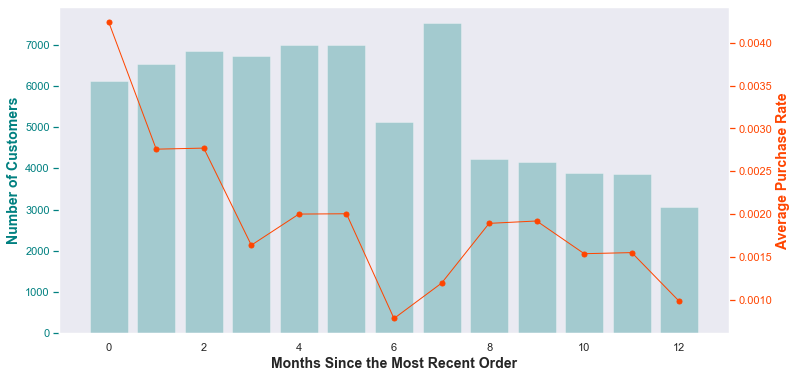

In [37]:
purch_rate_by_recency = df.groupby('order_recency')['purch'].mean().reset_index()

purch_rate_by_recency['orders'] = df.groupby('order_recency').size().reset_index()[0]

sns.set(style = 'dark')
f, ax = plt.subplots(figsize = (12, 6))

# create a secondary axis
ax2 = ax.twinx()

#bar chart for number of orders

ax.bar(purch_rate_by_recency['order_recency'], purch_rate_by_recency['orders'], color='teal', alpha=0.3)

ax2.plot(purch_rate_by_recency['order_recency'], purch_rate_by_recency['purch'], 
         color='orangered', marker='o', markersize=5, lw=1)

ax.set_xlabel('Months Since the Most Recent Order', fontsize=14, weight='bold')
ax.set_ylabel('Number of Customers', fontsize=14, weight='bold', color='teal')
ax2.set_ylabel('Average Purchase Rate', fontsize = 14, color='orangered', weight='bold')

ax.tick_params(axis='y', colors='teal')
ax2.tick_params(axis='y', colors='orangered')

### Model building

In [112]:
df.columns

Index(['customer_unique_id', 'order_recency', 'total_orders',
       'order_dow_Friday', 'order_dow_Monday', 'order_dow_Saturday',
       'order_dow_Sunday', 'order_dow_Thursday', 'order_dow_Tuesday',
       'order_dow_Wednesday', 'purch'],
      dtype='object')

In [113]:
# set-up

preds = df.columns[1:-1]

X = df[preds]
y = df['purch']

Tri-fold partitioning is recommended as long as there's sufficient sample size avaiable. In this example, since the number of target events is very small, we will perform a two-fold paritioning of the modeling sample.

Note that we could increase the size of the prediction window to capture more purchase events. However, for this exercise we will continue with the current prediction window (of one month).

#### Two-fold partition

In [117]:
# split the dataframe into train(50%) and test(50%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=314)

len(X_train), len(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36042, 9), (36043, 9), (36042,), (36043,))

In [118]:
# target distribution in the trainig sample

y_train.value_counts()

0    35973
1       69
Name: purch, dtype: int64

In [119]:
# target distribution in the test sample

y_test.value_counts()

0    35966
1       77
Name: purch, dtype: int64

In [123]:
from sklearn.linear_model import LogisticRegression

# define the model object ('liblinear' is recommended for small datasets), initialize classifier
clf = LogisticRegression(solver='liblinear', random_state=314)

# train (fit) the model using the training sample
clf.fit(X_train, y_train)

# make predictions on the test sample, contains 0's or 1's.
y_preds = clf.predict(X_test)

In [124]:
y_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### Model accuracy

In [122]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_preds)

0.9978636628471548

Why does the model appear to be very strong in spite of only two predictors that didn't look correlated with the target?

In [45]:
# check model's predictions against actual value of the target event

pd.crosstab(y_test, y_preds)

col_0,0
purch,
0,35966
1,77


The model is predicting 0 (no purchase) for all customers! Accuracy score is not a reliable measure while dealing with rare events. Let's take a look at a few additional metrics. (We will learn about these metrics in the class later.)

Area under the ROC curve (AUC)

In [125]:
from sklearn.metrics import roc_auc_score

# calculate the probabilities on the test sample
y_scores = clf.predict_proba(X_test)[:, 1]

# calcualte AUC
roc_auc_score(y_test, y_scores)

0.5361902041682947

Precision

In [126]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_scores)

average_precision

0.0037491967236356538

In [48]:
print(f'{y_scores.mean():.4f}, {y_train.mean():.4f}, {y_test.mean():.4f}')

0.0020, 0.0019, 0.0021


## Export results

#### 1. Scored dataset (with all model attributes)

In [127]:
scores_all = clf.predict_proba(df[preds])[:, 1]

df['prob_to_purchase'] = scores_all

df.head()

,customer_unique_id,order_recency,total_orders,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,purch,prob_to_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,0,0,0,0,1,0,0,0,0.003955
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,0,1,0,0,0,0,0,0,0.002920
2,0000f6ccb0745a6a4b88665a16c9f078,8,1,0,0,0,0,1,0,0,0,0.001722
3,0004aac84e0df4da2b147fca70cf8255,7,1,0,0,0,0,0,1,0,0,0.002201
4,0004bd2a26a76fe21f786e4fbd80607f,2,1,0,0,0,0,1,0,0,0,0.003512


In [129]:
csv_file_zipped = '../output/purch_model_scores.csv.gz'

df.to_csv(csv_file_zipped, compression='gzip')

#### 2. Export the model

In [130]:
import joblib

model_pkl_file = '../output/purch_model.joblib'

joblib.dump(clf, model_pkl_file)

['../output/purch_model.joblib']

##### Load the model

In [131]:
clf_loaded = joblib.load(model_pkl_file)

clf_loaded

LogisticRegression(random_state=314, solver='liblinear')

In [132]:
# use the model to score a "new" data frame

clf_loaded.predict_proba(X_test)

array([[9.99111062e-01, 8.88938378e-04],
       [9.98822863e-01, 1.17713703e-03],
       [9.98783584e-01, 1.21641603e-03],
       ...,
       [9.98042503e-01, 1.95749664e-03],
       [9.98569205e-01, 1.43079465e-03],
       [9.99164076e-01, 8.35923715e-04]])

# Oversampling

In [139]:
df_events = df[df['purch'] == 1]
df_nonevents = df[df['purch'] == 0].sample(len(df_events)) #picks same number of events. 

df_os = pd.concat([df_events, df_nonevents])
df_os.shape

(292, 12)

In [140]:
X_os = df_os[preds]
y_os = df_os['purch']

In [141]:
clf = LogisticRegression(solver='liblinear', random_state=314)

# train (fit) the model using the over-sampled data
clf.fit(X_os, y_os)

LogisticRegression(random_state=314, solver='liblinear')

In [142]:
y_preds = clf.predict(X)

In [143]:
accuracy_score(y, y_preds)

0.5210376638690435

In [138]:
pd.crosstab(y, y_preds)

col_0,0,1
purch,,
0,38233,33706
1,53,93


In [144]:
y_scores = clf.predict_proba(X)[:, 1]

# calcualte AUC
roc_auc_score(y, y_scores)

0.6108721392001253

Do you notice an issue with the way we validated this model?

The training data above is a subset of the original dataset. And then we used the original dataset for model validation. This is likely to give us a biased sense of how well the model works on unseen data. The training and test set should be mutually exclusive.

In [146]:
X_train_os, X_test_os, y_train_os, y_test_os = \
    train_test_split(X_os, y_os, test_size=0.5, random_state=314)

len(X_train_os), len(X_test_os)

(146, 146)

In [147]:
# train (fit) the model using the (oversampled) training sample
clf.fit(X_train_os, y_train_os)

# make predictions on the test sample
y_preds_os = clf.predict(X_test_os)

In [148]:
accuracy_score(y_test_os, y_preds_os)

0.5547945205479452

In [149]:
pd.crosstab(y_test_os, y_preds_os)

col_0,0,1
purch,,
0,46,25
1,40,35


In [150]:
y_scores_os = clf.predict_proba(X_test_os)[:, 1]

# calcualte AUC
roc_auc_score(y_test_os, y_scores_os)

0.5543661971830987

In [151]:
y_scores_os.mean()

0.49160011743225246

Because we trained our model on a dataset with over-sampled events, the predicted probabilities here are aligned with the event:non-event proportion in the training set.

Instead of manually oversampling, we can use `class_weight` to achieve the same results.

In [153]:
clf = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=314)

clf.fit(X_train, y_train)

clf.predict_proba(X_train)[:, 1].mean()

0.4736047864743716

In [69]:
y_scores = clf.predict_proba(X_test)[:, 1]

# calcualte AUC
roc_auc_score(y_test, y_scores)

0.5791839117897062

## _k_-fold Cross-validation

We used 50% of the dataset as a test set. Since the number of events in this dataset is very small, this is an expensive thing to do. Ideally, we'd like to train the model with more events to make it more generalizable. We can use _k_-fold cross-validation to achieve this.

In [154]:
# let's use three folds
k_folds = 3
clf = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=314)
auc_scores = []

for k in range(k_folds):
    
    X_train_k, X_test_k, y_train_k, y_test_k = \
        train_test_split(X, y, test_size=1/k_folds)

    clf.fit(X_train_k, y_train_k)
    
    y_scores_k = clf.predict_proba(X_test_k)[:, 1]

    # calcualte AUC
    auc = roc_auc_score(y_test_k, y_scores_k)
    
    auc_scores.append(auc)
    
print(auc_scores)

[0.550402096412495, 0.5354561133616169, 0.6520952142588984]


In [71]:
sum(auc_scores) / len(auc_scores)

0.5736409016441154

This shows us how well the model will work, on average, on unseen data.

__________________

<img src="../misc/purch-model-process.png" align=left width=750>